In [1]:
# datasets_subset.py is a copy of datasets.py 
# with filepaths changed to cluster filepaths and a new subsetting parameter for YFCC data
from datasets_subset import *

import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import models
import torch.utils.data # changed to prevent namespace pollution
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import torch



## If you want to use COCO for Testing (much faster initializing of dataset). It doesn't matter which dataset we use for this notebook's purposes since we are just testing the speed of model.forward() on different batch sizes

In [2]:
transform_train = transforms.Compose([           
        transforms.ToTensor(),                          
        ])
coco_data = CoCoDataset(transform_train)

dataloader = data.DataLoader(dataset=coco_data, 
              num_workers=0,
              batch_size=1,
              collate_fn=collate_fn)

loading annotations into memory...
Done (t=11.04s)
creating index...
index created!


In [3]:
len(dataloader)

82081

## If you want to use YFCC for Testing (slow initialization of dataset)

In [ ]:
transform_train = transforms.Compose([           
        transforms.ToTensor(),                          
        ])

dataset = YfccPlacesDataset(transform_train, 10, num_data_alex = 2000) # subset first 2k data

dataloader = data.DataLoader(dataset=dataset, 
              num_workers=0,
              batch_size=1,
              collate_fn=collate_fn)

In [ ]:
len(dataloader)

## Define two helper functions to perform the timing of model.forward() for different batch sizes

In [4]:
def get_batch(dataloader, batch_size = 64):
    '''
    The goal of this function is to return a batch
    of size batch_size as a torch tensor 
    of shape (batch_size, 3,3,224)
    '''
    print("batch method, batch size: {0}".format(batch_size))
    # initialize GPU and model
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model = models.alexnet(pretrained=True).to(device)
    new_classifier = nn.Sequential(*list(model.classifier.children())[:-1])
    model.classifier = new_classifier
    model.eval() # IMPORANT: turn off all model stochasticity for comparison


    # arrays to cache data for batching
    batched_big_data =[]
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    num_data = len(dataloader)

    for i, (data, target) in enumerate(tqdm(dataloader)):
        if data is None:
            continue
            
        # when we have accumulated batch_size data, 
        # early exit and return the batch
        if i == batch_size:
            print("batch obtained of size {0} obtained, returning".format(batch_size))
            all_big_data = torch.cat(batched_big_data, 0)
            return all_big_data
            
        # store data into batched_big_data[]
        data = normalize(data).to(device)
        big_data = F.interpolate(data.unsqueeze(0), size=224, mode='bilinear').to(device)
        # cache these results
        batched_big_data.append(big_data)

        

def timing_test(batch_data):
    # initialize GPU and model
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model = models.alexnet(pretrained=True).to(device)
    new_classifier = nn.Sequential(*list(model.classifier.children())[:-1])
    model.classifier = new_classifier
    model.eval() # IMPORANT: turn off all model stochasticity for comparison
    
    time_arr = []
    for _ in tqdm(range(1000)):
        start = time.time()
        #================================
        feature = model.forward(batch_dat)
        #================================
        end = time.time()
        time_arr.append(end-start)
    return np.mean(time_arr)

## Perform time tests for different batch sizes


In [21]:
forward_time = []
# batch_sizes = [100, 200, 300, 400, 500, 600]
batch_sizes = [16, 32, 64, 128, 256, 512]

for i in batch_sizes:
    batch_dat = get_batch(dataloader, i) # get a batch of size i
    print("beginning timing test, averaging over 1k executions of model.forward()")
    avg_execution_time = timing_test(batch_dat) # perform timing test
    
    forward_time.append(avg_execution_time)
    print(forward_time)
    print("================================")

batch method, batch size: 16


  0%|          | 0/82081 [00:00<?, ?it/s]/n/fs/revise-scr/alex/miniconda2/envs/toolenv/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
  0%|          | 16/82081 [00:00<27:23, 49.94it/s]


batch obtained of size 16 obtained, returning
beginning timing test, averaging over 1k executions of model.forward()


100%|██████████| 1000/1000 [00:02<00:00, 336.96it/s]


[0.002943152904510498]
batch method, batch size: 32


  0%|          | 32/82081 [00:00<23:47, 57.47it/s]


batch obtained of size 32 obtained, returning
beginning timing test, averaging over 1k executions of model.forward()


100%|██████████| 1000/1000 [00:04<00:00, 211.59it/s]


[0.002943152904510498, 0.004688525676727295]
batch method, batch size: 64


  0%|          | 64/82081 [00:01<24:32, 55.70it/s]


batch obtained of size 64 obtained, returning
beginning timing test, averaging over 1k executions of model.forward()


100%|██████████| 1000/1000 [00:10<00:00, 94.25it/s]


[0.002943152904510498, 0.004688525676727295, 0.010532344102859498]
batch method, batch size: 128


  0%|          | 128/82081 [00:02<24:46, 55.12it/s]


batch obtained of size 128 obtained, returning
beginning timing test, averaging over 1k executions of model.forward()


100%|██████████| 1000/1000 [00:19<00:00, 52.11it/s]


[0.002943152904510498, 0.004688525676727295, 0.010532344102859498, 0.0190606689453125]
batch method, batch size: 256


  0%|          | 256/82081 [00:04<23:45, 57.41it/s]


batch obtained of size 256 obtained, returning
beginning timing test, averaging over 1k executions of model.forward()


100%|██████████| 1000/1000 [00:32<00:00, 30.90it/s]


[0.002943152904510498, 0.004688525676727295, 0.010532344102859498, 0.0190606689453125, 0.03215593457221985]
batch method, batch size: 512


  1%|          | 512/82081 [00:08<23:47, 57.16it/s]


batch obtained of size 512 obtained, returning
beginning timing test, averaging over 1k executions of model.forward()


100%|██████████| 1000/1000 [00:58<00:00, 17.03it/s]

[0.002943152904510498, 0.004688525676727295, 0.010532344102859498, 0.0190606689453125, 0.03215593457221985, 0.05837333631515503]


## Plot trend of batch size vs avg execution time of model.forward() call

In [6]:
# find linear fit from data
x = np.asarray(batch_sizes)

m, b = np.polyfit(x, forward_time, 1)

Text(0.5, 1.0, 'average time (over 1k batches) it takes to process a SINGLE image')

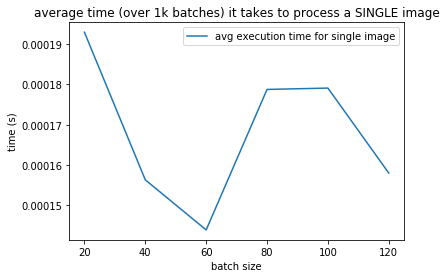

In [17]:
plt.plot(x, forward_time/x, label = "avg execution time for single image")
# plt.plot(x, x*m+b, label="linear fit", color = "red")
plt.xlabel("batch size")
plt.ylabel("time (s)")
plt.legend()


plt.title("average time (over 1k batches) it takes to process a SINGLE image")

Text(0.5, 1.0, 'average time (over 1k batches) it takes to process batch_size images')

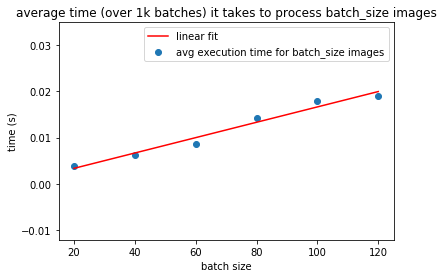

In [20]:
plt.scatter(x, forward_time, label = "avg execution time for batch_size images")
plt.plot(x, x*m+b, label="linear fit", color = "red")
plt.xlabel("batch size")
plt.ylabel("time (s)")
plt.legend()


plt.title("average time (over 1k batches) it takes to process batch_size images")